<a href="https://colab.research.google.com/github/denistoo749/Flower-Classification/blob/main/flower_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification of flowers Tutorial
This tutorial uses a dataset of several thousand photos of flowers. The flowers dataset contains five sub-directories, one per class:
```
flowers_photos/
  daisy/
  dandelion/
  roses/
  sunflowers/
  tulips/
```

# Load and preprocess images
- First, you will use high-level Keras preprocessing utilities (such as `tf.keras.utils.image_dataset_from_directory`) and layers (such as `tf.keras.layers.Rescaling`) to read a directory of images on disk.
- Next, you will write your own input pipeline from scratch [using tf.data](../../guide/data.ipynb).

### Setup

In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

In [2]:
print(tf.__version__)

2.15.0


# Download the flowers dataset
This tutorial uses a dataset of several thousand photos of flowers. The flowers dataset contains five sub-directories, one per class:

In [5]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
archive = tf.keras.utils.get_file(origin=dataset_url, extract=True)
data_dir = pathlib.Path(archive).with_suffix('')

228813984/228813984 [==============================] - 1s 0us/step


In [6]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


Each directory contains images of that type of flower. Here are some roses:

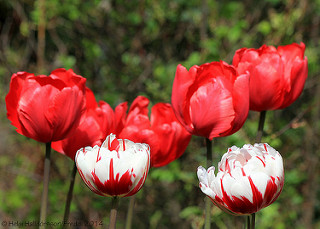

In [7]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

# Load data using a Keras utility
Let's load these images off disk using the helpful tf.keras.utils.image_dataset_from_directory utility.

Define some parameters for the loader:

In [8]:
batch_size = 32
img_height = 180
img_width = 180

It's good practice to use a validation split when developing your model. You will use 80% of the images for training and 20% for validation.

In [9]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [10]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


You can find the class names in the class_names attribute on these datasets.

In [11]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


# Visualize the data
Here are the first nine images from the training dataset.

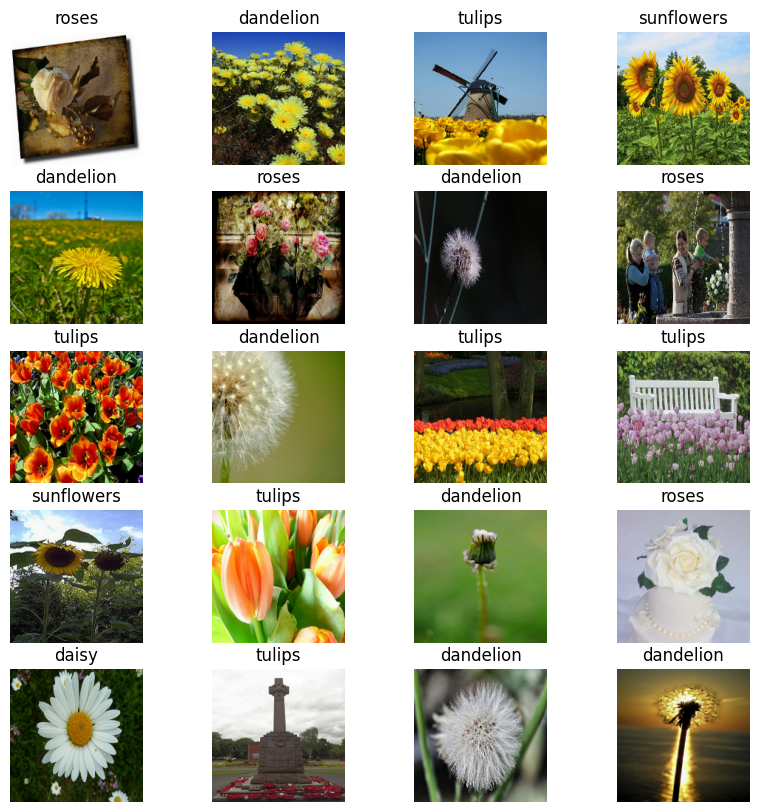

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(20):
    ax = plt.subplot(5, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### Configure the dataset for performance

Let's make sure to use buffered prefetching so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:

- `Dataset.cache` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
- `Dataset.prefetch` overlaps data preprocessing and model execution while training.

Interested readers can learn more about both methods, as well as how to cache data to disk in the *Prefetching* section of the [Better performance with the tf.data API](../../guide/data_performance.ipynb) guide.

In [27]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Train a model using these datasets by passing them to `model.fit`

In [13]:
num_classes = 5

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

Choose the `tf.keras.optimizers.Adam` optimizer and `tf.keras.losses.SparseCategoricalCrossentropy` loss function. To view training and validation accuracy for each training epoch, pass the `metrics` argument to `Model.compile`.

In [14]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

Note: You will only train for a few epochs so this tutorial runs quickly.

In [16]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10
)

Epoch 1/10
92/92 [==============================] - 7s 63ms/step - loss: 0.7426 - accuracy: 0.7149 - val_loss: 0.9381 - val_accuracy: 0.6403
Epoch 2/10
92/92 [==============================] - 6s 64ms/step - loss: 0.5765 - accuracy: 0.7803 - val_loss: 0.9209 - val_accuracy: 0.6540
Epoch 3/10
92/92 [==============================] - 6s 56ms/step - loss: 0.4590 - accuracy: 0.8362 - val_loss: 0.9294 - val_accuracy: 0.6676
Epoch 4/10
92/92 [==============================] - 7s 71ms/step - loss: 0.3127 - accuracy: 0.8900 - val_loss: 1.1538 - val_accuracy: 0.6676
Epoch 5/10
92/92 [==============================] - 9s 90ms/step - loss: 0.1923 - accuracy: 0.9349 - val_loss: 1.2535 - val_accuracy: 0.6785
Epoch 6/10
92/92 [==============================] - 6s 57ms/step - loss: 0.1205 - accuracy: 0.9588 - val_loss: 1.2942 - val_accuracy: 0.6730
Epoch 7/10
92/92 [==============================] - 8s 80ms/step - loss: 0.1122 - accuracy: 0.9642 - val_loss: 1.4437 - val_accuracy: 0.6866
Epoch 8/10
92

# Using tf.data for finer control
The above Keras preprocessing utility—`tf.keras.utils.image_dataset_from_directory`—is a convenient way to create a `tf.data.Dataset` from a directory of images.

For finer grain control, you can write your own input pipeline using `tf.data`. This section shows how to do just that, beginning with the file paths from the TGZ file you downloaded earlier.

In [17]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

In [18]:
for f in list_ds.take(5):
  print(f.numpy())

b'/root/.keras/datasets/flower_photos/daisy/16819071290_471d99e166_m.jpg'
b'/root/.keras/datasets/flower_photos/daisy/2812442552_3eed5fb9f2_m.jpg'
b'/root/.keras/datasets/flower_photos/dandelion/8756906129_b05a1b26f2.jpg'
b'/root/.keras/datasets/flower_photos/dandelion/18215579866_94b1732f24.jpg'
b'/root/.keras/datasets/flower_photos/dandelion/2674176237_e265ea64cc_n.jpg'


The tree structure of the files can be used to compile a `class_names` list.

In [20]:
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)

['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


Split the dataset into training and validation sets:

In [21]:
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

print the length of each dataset as follows:

In [22]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

2936
734


function that converts a file path to an (img, label) pair:

In [23]:
def get_label(file_path):
  # Convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)

In [24]:
def decode_img(img):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=3)
  # Resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

In [25]:
def process_path(file_path):
  label = get_label(file_path)
  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

Use `Dataset.map` to create a dataset of `image, label` pairs:

In [28]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [29]:
for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  3


### Configure dataset for performance
To train a model with this dataset you will want the data:

* To be well shuffled.
* To be batched.
* Batches to be available as soon as possible.

These features can be added using the `tf.data` API.

In [30]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

### Visualize the data

You can visualize this dataset similarly to the one you created previously:

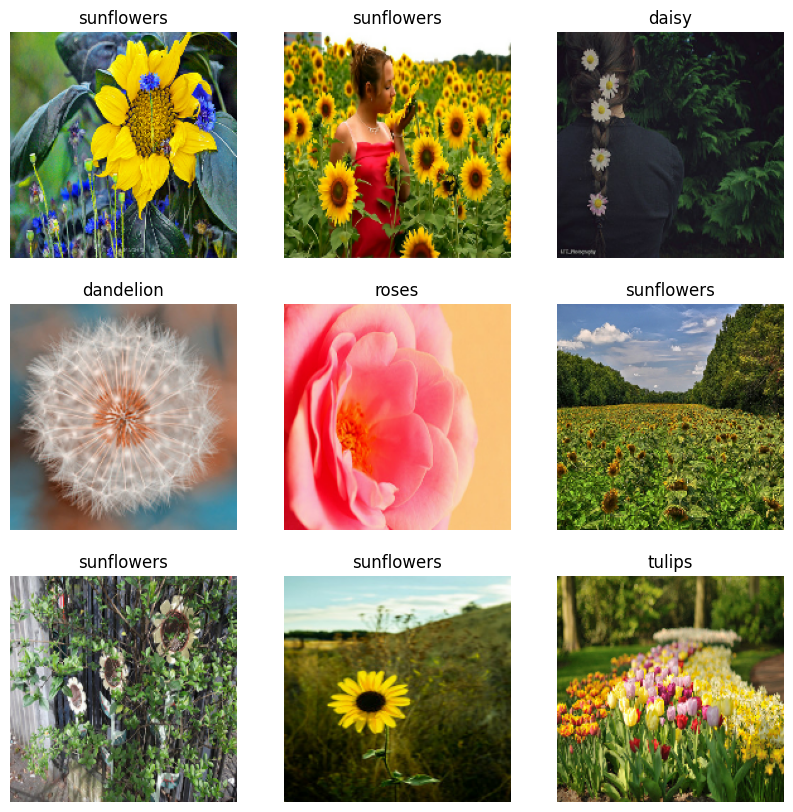

In [31]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

### Continue training the model

You have now manually built a similar `tf.data.Dataset` to the one created by `tf.keras.utils.image_dataset_from_directory` above. You can continue training the model with it. As before, you will train for just a few epochs to keep the running time short.

In [33]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10
)

Epoch 1/10
92/92 [==============================] - 3s 29ms/step - loss: 0.0409 - accuracy: 0.9867 - val_loss: 0.3664 - val_accuracy: 0.9074
Epoch 2/10
92/92 [==============================] - 3s 31ms/step - loss: 0.0172 - accuracy: 0.9969 - val_loss: 0.3673 - val_accuracy: 0.9292
Epoch 3/10
92/92 [==============================] - 3s 28ms/step - loss: 0.0048 - accuracy: 0.9997 - val_loss: 0.3982 - val_accuracy: 0.9292
Epoch 4/10
92/92 [==============================] - 3s 29ms/step - loss: 0.0044 - accuracy: 0.9997 - val_loss: 0.3860 - val_accuracy: 0.9305
Epoch 5/10
92/92 [==============================] - 3s 33ms/step - loss: 0.0060 - accuracy: 0.9990 - val_loss: 0.3847 - val_accuracy: 0.9292
Epoch 7/10
92/92 [==============================] - 3s 33ms/step - loss: 0.0035 - accuracy: 0.9993 - val_loss: 0.3927 - val_accuracy: 0.9264
Epoch 8/10
92/92 [==============================] - 3s 29ms/step - loss: 0.0041 - accuracy: 0.9993 - val_loss: 0.3981 - val_accuracy: 0.9305
Epoch 9/10
92